In [1]:
from utils import collect
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from math import pi
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import numpy as np


from pruneshift.networks import create_network
from pruneshift.prune_info import PruneInfo
from pruneshift.utils import get_model_complexity_prune

pio.renderers.default = 'iframe'

paths_combined = [Path("/work/dlclarge2/hoffmaja-pruneshift/shashank_runs/icml_runs_new/amda_resnet/")]
                  # Path("/work/dlclarge2/hoffmaja-pruneshift/shashank_runs/icml_runs/new/amda_resnet/l1_channels")]
                 # Path("/work/dlclarge2/hoffmaja-pruneshift/shashank_runs/icml_runs_new/mnasnet/"),
                 # Path("/work/dlclarge2/hoffmaja-pruneshift/shashank_runs/icml_runs_new/mobilenet_v2/")]
# path = Path("/work/dlclarge2/hoffmaja-pruneshift/experiments/img100/workshop/pruning")
path_baseline = Path("/work/dlclarge2/hoffmaja-pruneshift/experiments/img100/basemodels/resnet18_amda/")
# scaled_path = Path("/work/dlclarge2/hoffmaja-pruneshift/experiments/img100/basemodels/scaled_resnet18/")
# path_kd = Path("/work/dlclarge2/hoffmaja-pruneshift/experiments/img100/analysis/knowledge/")
sns.set_context("talk")
sns.set_style("ticks")

In [24]:
df_comb = collect(*paths_combined).query("Network == 'resnet18' & Scaling == 1.45 & not Teacher.isnull()")
df_baseline = collect(path_baseline)

In [25]:
df_pair = pd.concat([df_comb, df_baseline])

In [26]:
def calculate_info(row):
    path = Path(row["Path"]) / "checkpoint/last.ckpt"
    print(path)
    if not path.is_file():
        return np.NaN, np.NaN
    net = create_network("imagenet", row["Network"], 100, ckpt_path=path, scaling_factor=row["Scaling"])
    size = PruneInfo(net).network_size()
    macs, _ = get_model_complexity_prune(net, input_res=(3, 224, 224))
    return macs, size

def add_info(df):
    df[["MACs", "Model Size"]] = df[["Path", "Scaling", "Network"]].apply(calculate_info, axis=1, result_type="expand")
    return df

In [27]:
df_pair = add_info(df_pair)
# MAcs, ModelSize, Errors

/work/dlclarge2/hoffmaja-pruneshift/shashank_runs/icml_runs_new/amda_resnet/new/amda_resnet/global_weight/resnet18_scaled_1.0_kd_amda/checkpoint/last.ckpt
/work/dlclarge2/hoffmaja-pruneshift/shashank_runs/icml_runs_new/amda_resnet/new/amda_resnet/global_weight/resnet18_scaled_0.5_kd_amda/checkpoint/last.ckpt
/work/dlclarge2/hoffmaja-pruneshift/shashank_runs/icml_runs_new/amda_resnet/new/amda_resnet/global_weight/resnet50_amda_to_resnet18_2/checkpoint/last.ckpt
/work/dlclarge2/hoffmaja-pruneshift/shashank_runs/icml_runs_new/amda_resnet/new/amda_resnet/testing_l1_channels/resnet18_scaled_0.5_kd_amda/checkpoint/last.ckpt
/work/dlclarge2/hoffmaja-pruneshift/shashank_runs/icml_runs_new/amda_resnet/new/amda_resnet/l1_channels/resnet18_scaled_0.5_kd_amda/checkpoint/last.ckpt
/work/dlclarge2/hoffmaja-pruneshift/shashank_runs/icml_runs_new/amda_resnet/new/amda_resnet/l1_channels/resnet18_scaled_1.0_kd_amda/checkpoint/last.ckpt
/work/dlclarge2/hoffmaja-pruneshift/shashank_runs/icml_runs_new/amda

In [6]:
df_pair

,Amda,Augmix,DeepAugment,ImageNet100 Error,ImageNet100-C Error,ImageNet100-R Error,Loss,Network,Path,Prune Amount,Prune Method,Scaling,Teacher,MACs,Model Size
180,True,True,True,0.0770,0.226205,0.467538,KnowledgeDistill,resnet18,/work/dlclarge2/hoffmaja-pruneshift/shashank_r...,0.5,global_weight,1.45,Amda Resnet50,2.369886e+09,11760704.0
180,True,True,True,0.0904,0.252032,0.480277,KnowledgeDistill,resnet18,/work/dlclarge2/hoffmaja-pruneshift/shashank_r...,0.5,l1_channels,1.45,Amda Resnet50,1.945417e+09,11755187.0
90,True,True,True,0.1278,0.281395,0.535049,StandardLoss,resnet18,/work/dlclarge2/hoffmaja-pruneshift/experiment...,NaN,NaN,1.00,NaN,1.821716e+09,11227812.0


In [7]:
df_comb = df_pair.copy()

In [8]:
value_vars=["MACs", "Model Size", "ImageNet100 Error", "ImageNet100-R Error", "ImageNet100-C Error"]

max_error = max(df_comb[var].max() for var in value_vars[2: ])
scaling_factor = {"MACs": 2e9, "Model Size": 2.5e7, "ImageNet100 Error": max_error, "ImageNet100-R Error": max_error, "ImageNet100-C Error": max_error}

# First Normalize the values.
for var in value_vars:
    df_comb[var] /= scaling_factor[var]

In [9]:
fig = go.Figure()

for _, row in df_comb.iterrows():
    row = row.copy().to_frame().transpose()
    r = [row[var].item() for var in value_vars]
    distill = "with" if not row["Teacher"].isnull().item() == True else "without"

    
    if row["Prune Method"].isnull().item():
        prune_method = "without pruning"
    else:
        prune_method = "with " + row["Prune Method"].item()
        
    
    
    prune_amount = row["Prune Amount"].item()
    categories = value_vars
    fig.add_trace(go.Scatterpolar(
          r=r,
          theta=categories,
          fill='toself',
          name=f'Resnet18 {prune_method} {distill} distillation'
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1.25]
    )),
  showlegend=True,
)

fig.show()

<AxesSubplot:>

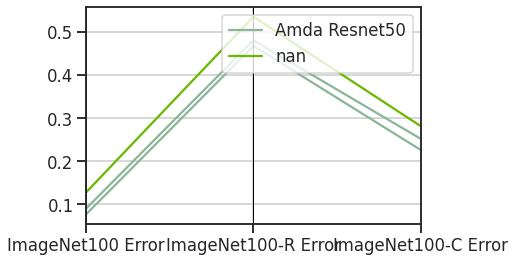

In [17]:
pd.plotting.parallel_coordinates(df_pair, "Teacher", cols=["ImageNet100 Error", "ImageNet100-R Error", "ImageNet100-C Error",])

In [33]:
df_filtered = df_pair.query("not `Prune Amount`.isnull()")

In [36]:
import plotly.express as px
fig = px.parallel_coordinates(df_filtered, color="Prune Amount",
                              dimensions=value_vars,
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=0.5)
fig.show()
